In [62]:
 ## to access the google drive with the google account
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
from PIL import Image
import os
import torch
import torchvision
import cv2
import argparse
import numpy as np
import random
import skimage
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as transforms
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage import io, segmentation
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from sklearn.cluster import KMeans
import torchvision.transforms.functional as F
from skimage.color import rgb2lab
import math


Original Image (Left) & Superpixel with the most Red pixels (Right):


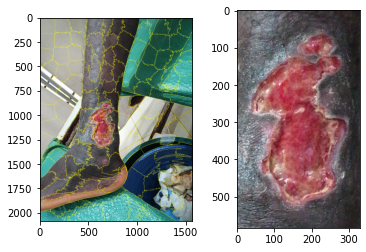

In [73]:
images = 'CD00000712_20210728103257_0002_20210929082024_20210929_082324.jpg'

folder = images[0:10]
image_path = '/content/drive/MyDrive/Skin_Disease/Skin_Images/' + folder + '/' + images + ''

sk_image = io.imread(image_path)

segment_slic = slic(sk_image, n_segments=150, compactness=10, sigma=1, start_label=0)

base_distance = 256
#distance that cannot be reached (too far) to set a baseline

red = 0

for index in np.unique(segment_slic):

  superpixel = (segment_slic == index)
  #make sure that the segment equals the current index and set variable superpixel equal to that

  average_superpixel_color = np.average(rgb2lab(sk_image[superpixel]),axis=0)
  #average color of each superpixel

  lab_superpixel_color = rgb2lab([[average_superpixel_color]])
  #turn the average color from rgb2lab so it can be compared mathematically

  avg_superpixel_red = np.clip(lab_superpixel_color,0,255,out=lab_superpixel_color)

  euclidean_distance = math.dist(avg_superpixel_red[0][0], [255,0,0])
  #comparing euclidean distance from color red to the average red color of each super pixel
  
  if euclidean_distance < base_distance:
    base_distance = euclidean_distance
    red = superpixel
    label = index
    #compare each distance from to see which super pixel has the smallest distance

red_id = np.where((np.unique(segment_slic))==label)[0][0]

#get most red superpixel mask
red_mask = (segment_slic == red_id)

#make bounding box of most red superpixel mask
bbox = np.array([np.min(np.where(red_mask)[0]),
                 np.max(np.where(red_mask)[0]),
                 np.min(np.where(red_mask)[1]),
                 np.max(np.where(red_mask)[1])])


#find middle of bouuding box
middle = np.array([bbox[2]+(bbox[3]-bbox[2])/2,bbox[0]+(bbox[1]-bbox[0])/2 ])

# Compute the new bounding box with 2x larger width and height
new_bbox = np.array([middle[0] - (bbox[3] - bbox[2]),
                     middle[0] + (bbox[3] - bbox[2]),
                    middle[1] - (bbox[1] - bbox[0]),
                     middle[1] + (bbox[1] - bbox[0])])

#round bbox so it can crop new image 
final_bbox = np.round(new_bbox).astype(int)

#apply new crop
cropped = sk_image.copy()[final_bbox[2]:final_bbox[3], final_bbox[0]:final_bbox[1]]

plt.show()
print('Original Image (Left) & Superpixel with the most Red pixels (Right):')
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(sk_image,segment_slic))

plt.subplot(1, 2, 2)
plt.imshow(cropped)


plt.show()
